## Aggregation of multidop statistics onto RRM grid

This takes Ben Hillman's TWP grids and aggregates statistics of reflectivty and
vertical velocity onto said grids.

In [4]:
import pyart
from scipy import interpolate
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection
from matplotlib import path
%matplotlib inline
import cartopy
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import math

In [23]:
twp_grid_path = '/home/rjackson/data/twp_grid/twpx4v1np4b_scrip_170613.nc'
twp_grid_latlon = '/home/rjackson/data/twp_grid/twpx4v1np4b_latlon_170613.nc'
example_multidop_file = '/home/rjackson/multidop_grids/cf_compliant_grid200511200300.nc'
weights_file = '/home/rjackson/data/twp_grid/multidop_weights.nc'
multidop_scrip_file = '/home/rjackson/data/twp_grid/multidop_scrip.nc'

twp_grid_dataset = Dataset(twp_grid_path)
latlon_dataset = Dataset(twp_grid_latlon)
weights_dataset = Dataset(weights_file)
multidop_scrip_dataset = Dataset(multidop_scrip_file)

multidop_grid = pyart.io.read_grid(example_multidop_file)
grid_corner_lon = twp_grid_dataset.variables['grid_corner_lon']
grid_corner_lat = twp_grid_dataset.variables['grid_corner_lat']
grid_center_lat = twp_grid_dataset.variables['grid_center_lat']
grid_center_lon = twp_grid_dataset.variables['grid_center_lon']
grid_corner_lon_mdop = multidop_scrip_dataset.variables['grid_corner_lon'][:]
grid_corner_lat_mdop = multidop_scrip_dataset.variables['grid_corner_lat'][:]
grid_center_lat_mdop = multidop_scrip_dataset.variables['grid_center_lat'][:]
grid_center_lon_mdop = multidop_scrip_dataset.variables['grid_center_lon'][:]
latlon_corners = latlon_dataset.variables['lon']
print(grid_corner_lat_mdop)

[[-12.69866101 -12.69866101 -12.68977207 -12.68977207]
 [-12.69866101 -12.69866101 -12.68977207 -12.68977207]
 [-12.69866101 -12.69866101 -12.68977207 -12.68977207]
 ..., 
 [-11.98754526 -11.98754526 -11.97865631 -11.97865631]
 [-11.98754526 -11.98754526 -11.97865631 -11.97865631]
 [-11.98754526 -11.98754526 -11.97865631 -11.97865631]]


In [6]:
size = grid_corner_lon.shape
num_hexagons = size[0]

In [7]:
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

(-12.7, -12.0)

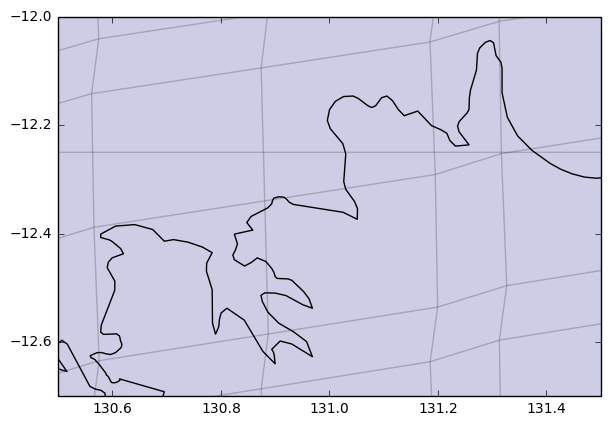

In [8]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
hexagons = []
hexagon_paths = []

for i in range(0,num_hexagons):
    vertex_list = [[x,y] for (x,y) in zip(grid_corner_lon[i],grid_corner_lat[i])]
    hexagons.append(patches.Polygon(vertex_list, closed=True, fill=False))
p = PatchCollection(hexagons, alpha=0.1)
colors = 100*np.ones(num_hexagons)
p.set_array(colors)
ax.add_collection(p)
ax.coastlines(resolution='10m')
ax.set_xticks([130.4, 130.6, 130.8, 
               131.0, 131.2, 131.4, 131.6], crs=ccrs.PlateCarree())
ax.set_yticks([-12.8, -12.6, -12.4, 
               -12.2, -12.0], crs=ccrs.PlateCarree())

plt.xlim((130.5, 131.5))
plt.ylim((-12.7, -12.0))

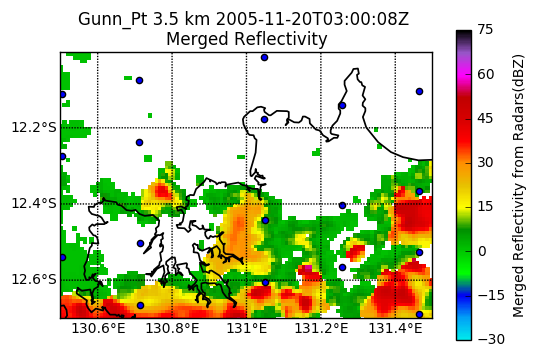

In [9]:
grid_display = pyart.graph.GridMapDisplay(multidop_grid)
grid_display.plot_basemap(min_lat=-12.7, max_lat=-12.0,
                          min_lon=130.5, max_lon=131.5,
                          auto_range=False,
                          lat_lines=[-12.8, -12.6, -12.4, 
                                     -12.2, -12.0],
                          lon_lines=[130.4, 130.6, 130.8, 
                                     131.0, 131.2, 131.4, 131.6],
                          resolution='h')
grid_display.plot_grid('reflectivity', level=6)

# Get polygons whose centers are within Multidop domain
within_lats = np.logical_and(grid_center_lon[:] > 130.5,
                             grid_center_lon[:] < 131.5)
within_lons = np.logical_and(grid_center_lat[:] > -12.7,
                             grid_center_lat[:] < -12.0)
the_inds = np.where(np.logical_and(within_lats, within_lons))

rrm_grid_x, rrm_grid_y = grid_display.basemap(grid_center_lon[the_inds], 
                                              grid_center_lat[the_inds])
plt.scatter(rrm_grid_x, rrm_grid_y)

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


[60337 60340 60343 60346 60347 60394 60395 60396 60422 60423 60425 60426
 60433 60434 60435 60436 60437 60438]


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1474: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  y0 = ma.minimum(y)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1475: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  y1 = ma.maximum(y)


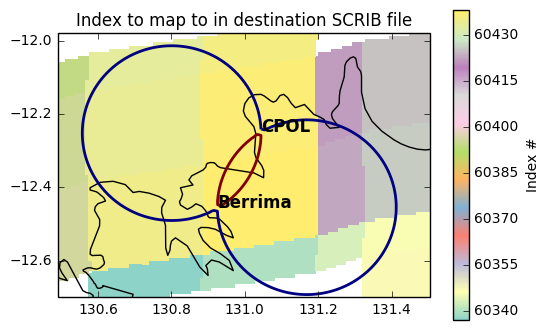

In [101]:
lons_grid, lats_grid = multidop_grid.get_point_longitude_latitude(level=0)
points = np.ma.zeros(lons_grid.shape)
zones = -99.0*np.ma.ones(lons_grid.shape)
bca = get_bca(multidop_grid)

for i in the_inds:
    vertex_list = [[x,y] for (x,y) in zip(grid_corner_lon[i],
                                          grid_corner_lat[i])]
    vertex_list = np.array(vertex_list)


# Close the shape!
vertex_list[:,:,5] = vertex_list[:,:,0]

for i in range(0,len(the_inds[0])):
    the_path = path.Path(np.transpose(vertex_list[i]))
    for j in range(0,points.shape[0]):
        for k in range(0,points.shape[1]):
            if(the_path.contains_point((lons_grid[j,k], lats_grid[j,k])) == True):
                points[j,k] = the_inds[0][i]
                zones[j,k] = i
                
points = np.ma.masked_where(points == 0, points)
zones = np.ma.masked_where(zones == -99.0, zones)
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons_grid, lats_grid, 
               points, vmin=min(the_inds[0]), vmax=max(the_inds[0]),
               cmap='Set3')
bar = plt.colorbar()
bar.set_label('Index #')
plt.contour(lons_grid, lats_grid, bca, latlon='True',
            levels=[math.pi/6, 5*math.pi/6], linewidths=2)
ax.coastlines(resolution='10m')
ax.set_xticks([130.6, 130.8, 
               131.0, 131.2, 131.4], crs=ccrs.PlateCarree())
ax.set_yticks([-12.6, -12.4, 
               -12.2, -12.0], crs=ccrs.PlateCarree())
cpol_latitude = -12.249166
cpol_longitude = 131.04445
berr_latitude = -12.456944
berr_longitude = 130.925
plt.annotate('Berrima', xy=(berr_longitude, berr_latitude), 
             xycoords='data', fontweight='bold',
             fontsize=12)
plt.annotate('CPOL', xy=(cpol_longitude, cpol_latitude), 
             xycoords='data', fontweight='bold',
             fontsize=12)
plt.title('Index to map to in destination SCRIB file')

## Map from Cf/Radial to Multidop SCRIB file

8991


(-12.7, -12.0)

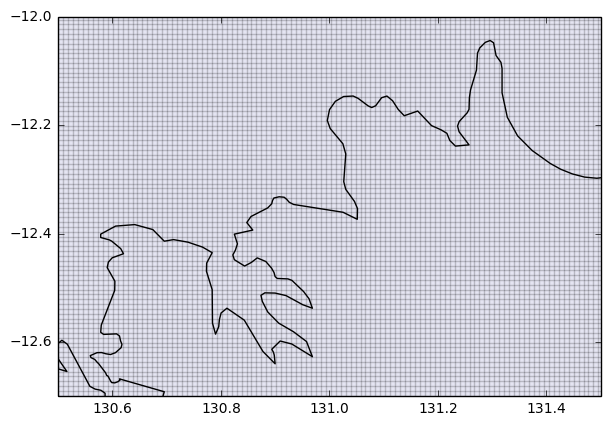

In [95]:
size = grid_corner_lon_mdop.shape
num_hexagons = size[0]
print(num_hexagons)
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
hexagons = []
hexagon_paths = []

for i in range(0,num_hexagons):
    vertex_list = [[x,y] for (x,y) in zip(grid_corner_lon_mdop[i],grid_corner_lat_mdop[i])]
    hexagons.append(patches.Polygon(vertex_list, closed=True, fill=False))
p = PatchCollection(hexagons, alpha=0.1)
colors = 100*np.ones(num_hexagons)
p.set_array(colors)
ax.add_collection(p)
ax.coastlines(resolution='10m')
ax.set_xticks([130.4, 130.6, 130.8, 
               131.0, 131.2, 131.4, 131.6], crs=ccrs.PlateCarree())
ax.set_yticks([-12.8, -12.6, -12.4, 
               -12.2, -12.0], crs=ccrs.PlateCarree())

plt.xlim((130.5, 131.5))
plt.ylim((-12.7, -12.0))

In [304]:
# Get polygons whose centers are within Multidop domain
within_lats = np.logical_and(grid_center_lon_mdop[:] >= 130.0,
                             grid_center_lon_mdop[:] <= 132)
within_lons = np.logical_and(grid_center_lat_mdop[:] >= -13,
                             grid_center_lat_mdop[:] <= -11.5)
the_inds = np.where(np.logical_and(within_lats, within_lons))
the_inds = np.where(np.logical_and(within_lats, within_lons))
lons_grid, lats_grid = multidop_grid.get_point_longitude_latitude(level=0)
points = np.ma.zeros(lons_grid.shape)
zones = -99.0*np.ma.ones(lons_grid.shape)
bca = get_bca(multidop_grid)
print(grid_corner_lon_mdop.shape)
vertex_list = []
for i in the_inds:
    vertex_list = [[x,y] for (x,y) in zip(grid_corner_lon_mdop[i],
                                          grid_corner_lat_mdop[i])]
    vertex_list = np.array(vertex_list)

# Close the shape!
#vertex_list[:,:,3] = vertex_list[:,:,0]

for i in range(0,len(the_inds[0])):
    if(i % 1000 == 0):
        print(str(i) + '/' + str(grid_corner_lon_mdop.shape[0]*4))
    the_path = path.Path(np.transpose(vertex_list[i]))
    for j in range(0,points.shape[0]):
        for k in range(0,points.shape[1]):
            if(the_path.contains_point((lons_grid[j,k], lats_grid[j,k])) == True):
                points[j,k] = the_inds[0][i]
                zones[j,k] = i
                
points = np.ma.masked_where(points == 0, points)
zones = np.ma.masked_where(zones == -99.0, zones)

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


(8991, 4)
0/35964
1000/35964
2000/35964
3000/35964
4000/35964
5000/35964
6000/35964
7000/35964
8000/35964


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1474: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  y0 = ma.minimum(y)
/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1475: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  y1 = ma.maximum(y)


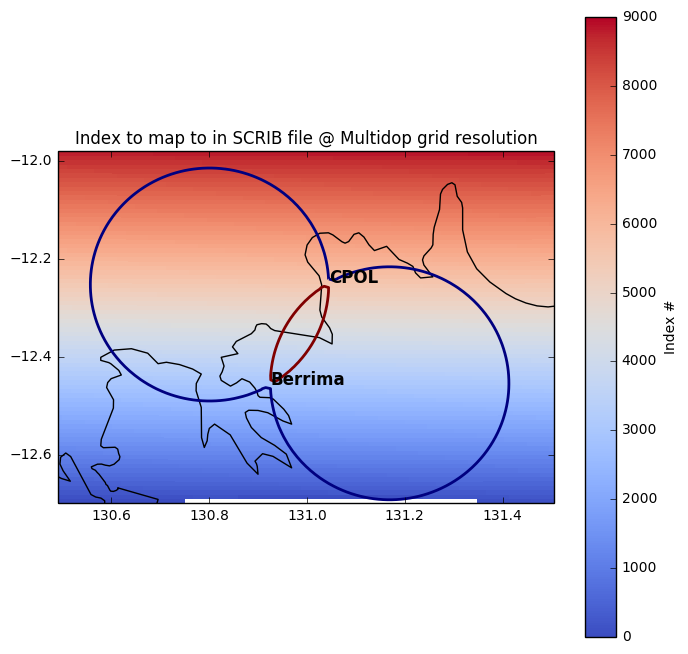

In [324]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons_grid, lats_grid, 
               zones, vmin=0, vmax=9000,
               cmap='coolwarm')
bar = plt.colorbar()
bar.set_label('Index #')
plt.contour(lons_grid, lats_grid, bca, latlon='True',
            levels=[math.pi/6, 5*math.pi/6], linewidths=2)
ax.coastlines(resolution='10m')
ax.set_xticks([130.6, 130.8, 
               131.0, 131.2, 131.4], crs=ccrs.PlateCarree())
ax.set_yticks([-12.6, -12.4, 
               -12.2, -12.0], crs=ccrs.PlateCarree())
cpol_latitude = -12.249166
cpol_longitude = 131.04445
berr_latitude = -12.456944
berr_longitude = 130.925
plt.annotate('Berrima', xy=(berr_longitude, berr_latitude), 
             xycoords='data', fontweight='bold',
             fontsize=12)
plt.annotate('CPOL', xy=(cpol_longitude, cpol_latitude), 
             xycoords='data', fontweight='bold',
             fontsize=12)
plt.title('Index to map to in SCRIB file @ Multidop grid resolution')

In [325]:
import xarray
ds = xarray.Dataset({'scrib_index': (['y','x'], points)},
                    coords={'lon': (['y','x'], lons_grid),
                            'lat': (['y','x'], lats_grid)},
                    attrs={'units': 'index', 'long_name': 'Mapping function to SCRIB'})
ds.to_netcdf(path='~/data/twp_grid/multidop_cfradial_to_scrib_mapping.nc')

## Aggregate onto RRM grid

In [127]:
reflectivity = multidop_grid.fields['reflectivity']['data']
u = multidop_grid.fields['eastward_wind']['data']
v = multidop_grid.fields['northward_wind']['data']
w = multidop_grid.fields['upward_air_velocity']['data']

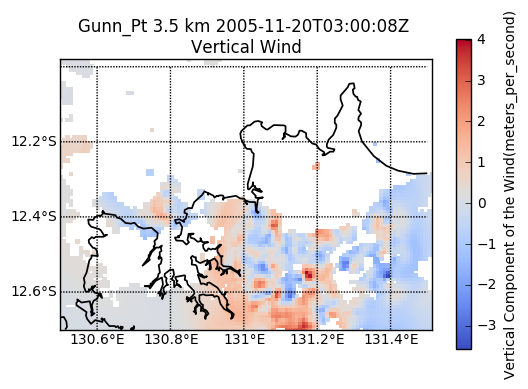

In [326]:
display = pyart.graph.GridMapDisplay(multidop_grid)
grid_display.plot_basemap(min_lat=-12.7, max_lat=-12.0,
                          min_lon=130.5, max_lon=131.5,
                          auto_range=False,
                          lat_lines=[-12.8, -12.6, -12.4, 
                                     -12.2, -12.0],
                          lon_lines=[130.4, 130.6, 130.8, 
                                     131.0, 131.2, 131.4, 131.6],
                          resolution='h')
display.plot_grid('upward_air_velocity', level=6, cmap='coolwarm')

Aggregation code from ESMF documentation 


 The following code shows how to apply the weights in the weight file to interpolate a source field (src_field) defined over the source grid to a destination field (dst_field) defined over the destination grid. The variables n_s, n_b, row, col, and S are from the weight file.

 ! Initialize destination field to 0.0
 
 do i=1, n_b
 
   dst_field(i)=0.0
   
 enddo

 ! Apply weights
 
 do i=1, n_s
 
   dst_field(row(i))=dst_field(row(i))+S(i)*src_field(col(i))
   
 enddo

If the first-order conservative interpolation method is specified ("-m conserve") then the destination field may need to be adjusted by the destination fraction (frac_b). This should be done if the normalization type is ``dstarea'' and if the destination grid extends outside the unmasked source grid. If it isn't known if the destination extends outside the source, then it doesn't hurt to apply the destination fraction. (If it doesn't extend outside, then the fraction will be 1.0 everywhere anyway.) The following code shows how to adjust an already interpolated destination field (dst_field) by the destination fraction. The variables n_b, and frac_b are from the weight file:

 ! Adjust destination field by fraction
 do i=1, n_b
 
   if (frac_b(i) .ne. 0.0) then
   
      dst_field(i)=dst_field(i)/frac_b(i)
      
   endif
   
 enddo


In [337]:
dest_corners_lat = weights_dataset['yv_b'][:]
dest_centers_lat = weights_dataset['yc_b'][:]
dest_corners_lon = weights_dataset['xv_b'][:]
dest_centers_lon = weights_dataset['xc_b'][:]
S = weights_dataset['S'][:]
row = weights_dataset['row'][:]
col = weights_dataset['col'][:]
frac_b = weights_dataset['frac_b'][:]
w_dest = np.nan*np.zeros(dest_centers_lat.shape)
count = np.zeros(dest_centers_lat.shape)
for i in range(0, len(S)):
    equivalent_point = np.where(points == col[i]-1)
    if(len(equivalent_point[0]) > 0):
        w_src = w[6,equivalent_point[0], equivalent_point[1]]
        if(w_src > -999.0):
            if(not np.isfinite(w_dest[row[i]-1])):
                w_dest[row[i]-1] = 0

            w_dest[row[i]-1] = w_dest[row[i]-1] + S[i]*w_src
            count[row[i]-1] += 1
            
w_dest[frac_b != 0] = w_dest[frac_b != 0]/frac_b[frac_b != 0] 
w_dest[count < 50] = np.nan

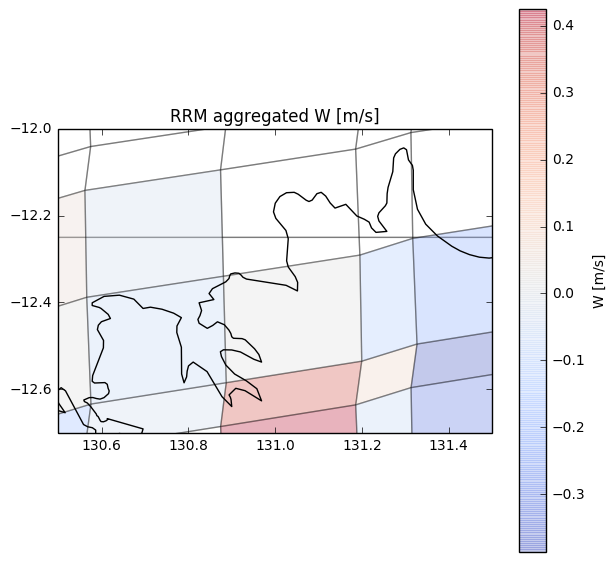

In [338]:
fig = plt.figure(figsize=(7,7))
size = dest_corners_lon.shape
num_hexagons = size[0]
ax = plt.axes(projection=ccrs.PlateCarree())
hexagons = []
hexagon_paths = []

for i in range(0,num_hexagons):
    vertex_list = [[x,y] for (x,y) in zip(dest_corners_lon[i],dest_corners_lat[i])]
    hexagons.append(patches.Polygon(vertex_list, closed=True, fill=False))
    
p = PatchCollection(hexagons, alpha=0.3, cmap='coolwarm')
colors = np.ma.masked_where(np.isnan(w_dest), w_dest)
p.set_array(colors)
ax.add_collection(p)
ax.coastlines(resolution='10m')
ax.set_xticks([130.4, 130.6, 130.8, 
               131.0, 131.2, 131.4, 131.6], crs=ccrs.PlateCarree())
ax.set_yticks([-12.8, -12.6, -12.4, 
               -12.2, -12.0], crs=ccrs.PlateCarree())

plt.xlim((130.5, 131.5))
plt.ylim((-12.7, -12.0))
cbar = fig.colorbar(p, ax=ax)
cbar.set_label('W [m/s]')
ax.set_title('RRM aggregated W [m/s]')

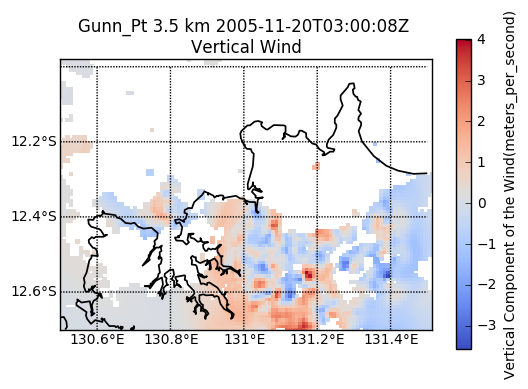

In [336]:
display = pyart.graph.GridMapDisplay(multidop_grid)
grid_display.plot_basemap(min_lat=-12.7, max_lat=-12.0,
                          min_lon=130.5, max_lon=131.5,
                          auto_range=False,
                          lat_lines=[-12.8, -12.6, -12.4, 
                                     -12.2, -12.0],
                          lon_lines=[130.4, 130.6, 130.8, 
                                     131.0, 131.2, 131.4, 131.6],
                          resolution='h')
display.plot_grid('upward_air_velocity', level=6, cmap='coolwarm')

3613


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
